<a href="https://colab.research.google.com/github/shlok2740/kaggle/blob/main/RTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rice Type Classificaton on Kaggle


In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shlokkumar2303
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
data_df.dropna(inplace=True)
data_df.drop(['id'] , axis = 1, inplace = True)
print(data_df.shape)

(18185, 11)


In [ ]:
print(data_df["Class"].unique())
print(data_df["Class"].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


In [ ]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column] / data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [ ]:
X = np.array(data_df.iloc[:, :-1])
Y = np.array(data_df.iloc[:, -1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.3)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5)

In [ ]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [ ]:
training_data = dataset(X_train,y_train)
testing_data = dataset(X_test,y_test)
validation_data = dataset(X_val,y_val)

In [ ]:
training_dataloader = DataLoader(training_data, batch_size = 32, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size = 32, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size = 32, shuffle= True)

In [ ]:
HIDDEN_LAYERS = 10

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1],HIDDEN_LAYERS)
    self.linear = nn.Linear(HIDDEN_LAYERS,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)

In [ ]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
  total_acc_train = 0
  total_acc_val = 0
  total_loss_train = 0
  total_loss_val = 0

  for data in training_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, labels)

    total_loss_train += batch_loss.item()

    acc = ((prediction).round() == labels).sum().item()

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)

      batch_loss = criterion(prediction, labels)

      total_loss_val += batch_loss.item()

      acc = ((prediction).round() == labels).sum().item()

      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))


  print(f'''Epoch No. {epoch+1} Train Loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)}
        Validation Loss: {round(total_loss_val/1000, 4)}  Validation Accuracy: {round(total_acc_val/validation_data.__len__() * 100, 4)}''')

  print('='*25)

Epoch No. 1 Train Loss: 0.1085 Train Accuracy: 80.9349
        Validation Loss: 0.1177  Validation Accuracy: 89.2223
Epoch No. 2 Train Loss: 0.0915 Train Accuracy: 94.7571
        Validation Loss: 0.094  Validation Accuracy: 96.465
Epoch No. 3 Train Loss: 0.0695 Train Accuracy: 96.8469
        Validation Loss: 0.0683  Validation Accuracy: 97.2349
Epoch No. 4 Train Loss: 0.0497 Train Accuracy: 97.7269
        Validation Loss: 0.0486  Validation Accuracy: 97.7376
Epoch No. 5 Train Loss: 0.0358 Train Accuracy: 98.0568
        Validation Loss: 0.0358  Validation Accuracy: 97.9262
Epoch No. 6 Train Loss: 0.027 Train Accuracy: 98.2218
        Validation Loss: 0.0279  Validation Accuracy: 98.1147
Epoch No. 7 Train Loss: 0.0215 Train Accuracy: 98.3135
        Validation Loss: 0.023  Validation Accuracy: 98.3346
Epoch No. 8 Train Loss: 0.0178 Train Accuracy: 98.5335
        Validation Loss: 0.0194  Validation Accuracy: 98.1147
Epoch No. 9 Train Loss: 0.0153 Train Accuracy: 98.4601
        Valid

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction, labels).item()

    total_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()

    total_acc_test += acc

print("Accuracy:",round(total_acc_test/testing_data.__len__() * 100, 4))

Accuracy: 98.6017


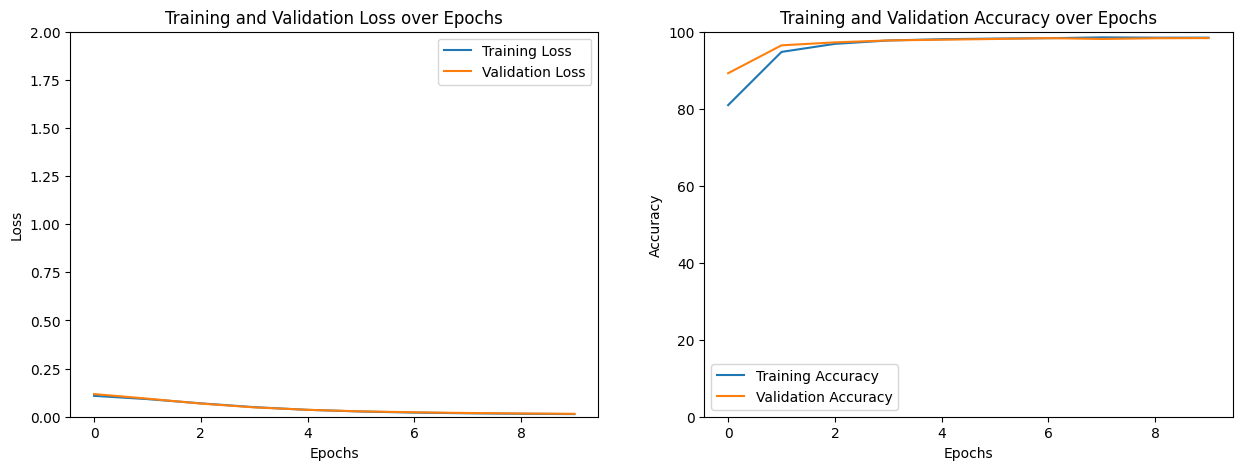

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_validation_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()